# Value at Risk (VaR) im kollektiven Modell (elementare Versicherungsmathematik)


## 1. Definition V@R

Der Value at Risk (VaR) von einer Zufallsvariablen $  W  $ zum Niveau $  \beta \in (0,1)  $ ist definiert als:

$$VaR_\beta(S) = \inf \{ x \in \mathbb{R} \mid F_S(x) \geq \beta \}$$

Dies entspricht dem unteren $  \beta  $-Quantil von $  S  $. Im kollektiven Modell der Versicherungsmathematik versucht man, die Gesamtschadenslast $  S  $ eines ganzen Versicherungskollektivs zu modellieren und zu verstehen.
Der Value at Risk (VaR) ist in diesem Zusammenhang eines der wichtigsten Werkzeuge, um zu beantworten:

>„Wie hoch muss unser Kapital / unsere Sicherheitsmittel mindestens sein, damit die Wahrscheinlichkeit, dass die tatsächlichen Schäden unser Geld übersteigen, sehr klein bleibt?“

**Ganz einfache Kernidee des VaR im kollektiven Modell**

Angenommen, ein Portfolio mit 100000 Verträgen, so gibt es mal wenige, mal viele, mal kleine und mal richtig teure Verträge (Schäden).
Die Gesamtschadenssumme $  S  $ kann sehr unterschiedlich ausfallen.
Der VaR sagt nun:

>„Bei einem Sicherheitsniveau von z. B. 99,5 % ist die Gesamtschadensumme S mit 99,5-prozentiger Wahrscheinlichkeit höchstens so hoch wie der VaR-Wert.“

Oder umgekehrt formuliert:

>„Nur in den schlechtesten 0,5 % aller möglichen Jahre werden die Schäden höher sein als dieser Betrag.“
>
Genau dieser Betrag heißt dann VaR_{99,5 %}(S).

**Visuelle Vorstellung**
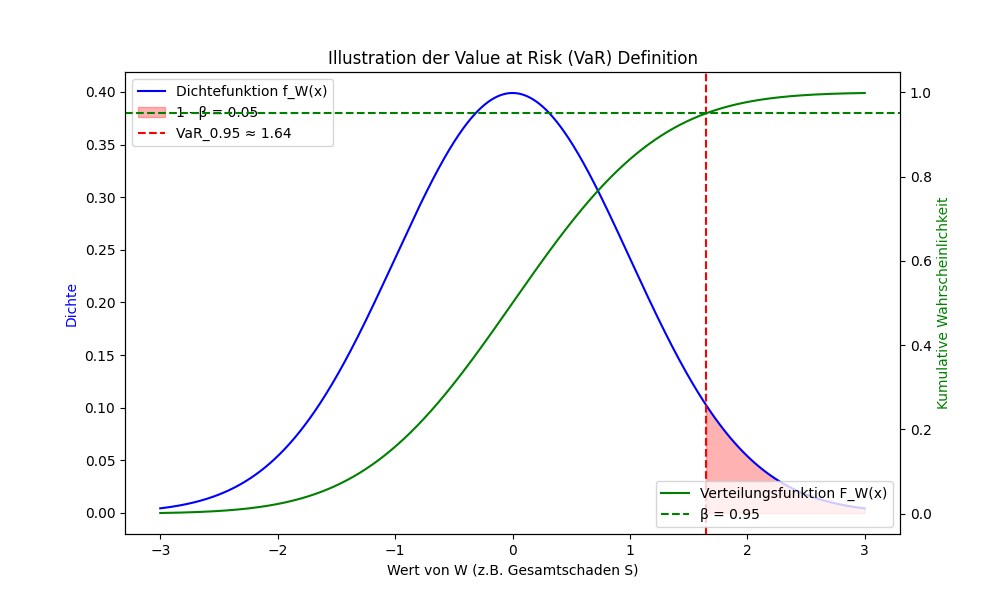

## 2. Algorithmus zur Berechnung des VaR für den Gesamtschaden im kollektiven Modell 

Im kollektiven Modell ist der Gesamtschaden $  S = \sum_{j=1}^N X_j  $, wobei $  N  $ die Schadenzahl (aus der Panjer-Klasse, z.B. Poisson) und $  X_j  $ die Schadenhöhen sind (unabhängig, identisch verteilt, ganzzahlig nichtnegativ).
Zur Berechnung von $  VaR_\beta(S)  $ wird die Panjer-Rekursion verwendet, um die Wahrscheinlichkeitsmassenfunktion $  p_S(k) = P(S = k)  $ zu berechnen. Dann kumuliert man die Verteilungsfunktion iterativ:

1. Schritt: Setze $  k := 0  $, berechne $  s_k = p_S(k)  $.
2. Schritt: Wenn $  s_k \geq \beta  $, dann $  VaR_\beta(S) = k  $; Abbruch, andernfalls Schrit 3.
3. Schritt: setze $  k := k + 1  $, berechne $  p_S(k)  $, setze $  s_k = s_k + p_S(k)  $, gehe zu Schritt 2.

Dies konvergiert gegen $  VaR_\beta(S)  $.
Bemerkung: In der Praxis schätzt man die Verteilungen von $  N  $ und $  X  $ zuerst.

## 3. Python-Code mit Beispiel
Beispiel: Elementare Sachversicherungsmathematik

- $  N \sim Poi(\lambda = 5)  $ (durchschnittlich 5 Schäden pro Periode).
- $  X \sim Geom(p = 0.5)  $ (Schadenhöhen starten bei 1, E[X] = 2, ganzzahlig).
Berechne $  VaR_{0.95}(S)  $ (95%-Niveau).

In [4]:
import numpy as np
from scipy.stats import poisson, binom, nbinom  # Für die Berechnung von p_S(0) bei bekannten Verteilungen

def panjer_recursion(a, b, p_X, max_k=10000):
    """
    Berechnet die PMF p_S(k) für k=0 bis max_k unter Verwendung der Panjer-Rekursion.
    
    Parameters:
    - a, b: Rekursionsparameter der Panjer-Klasse (z.B. Poisson: a=0, b=lambda)
    - p_X: Array mit P(X=k) für k=0 bis len(p_X)-1 (Schadenhöhen-PMF, sum=1)
    - max_k: Maximale k, bis zu der rekursiv gerechnet wird (zur Vermeidung unendlicher Loops)
    
    Returns:
    - p_S: Array mit p_S[k] für k=0 bis max_k
    """
    m_X = len(p_X)  # Maximale Schadenhöhe (angenommen endlich)
    p_S = np.zeros(max_k + 1)
    
    # p_S(0) = P_N(p_X[0]), aber für Panjer approximativ oder exakt
    # Hier Annahme: Wir verwenden die Rekursion, aber p_0 muss separat
    p0 = p_X[0]
    if a == 0:  # Poisson, b=lambda
        p_S[0] = np.exp(b * (p0 - 1))
    elif a < 0:  # Binomial, a = -p/(1-p), b=(n+1)p/(1-p), extrahiere n, p
        p = -a / (1 - a)
        n = (b / (1 - a)) - 1
        p_S[0] = (1 - p + p * p0)**n
    elif a > 0:  # Negative Binomial, a=p, b=p*(alpha-1), alpha = (b/a) +1
        alpha = (b / a) + 1
        p_S[0] = (1 - a / (1 - a * p0))** (-alpha)
    else:
        raise ValueError("Unbekannte Panjer-Parameter")
    
    # Faktor für die Rekursion
    denom = 1 - a * p0
    if denom <= 0:
        raise ValueError("Denominator <=0 in Panjer-Rekursion")
    
    for k in range(1, max_k + 1):
        sum_term = 0.0
        for l in range(1, min(k, m_X - 1) + 1):
            coeff = a + (b * l) / k
            sum_term += coeff * p_X[l] * p_S[k - l]
        p_S[k] = sum_term / denom
    
    # Normalisiere, falls Summe nicht genau 1 (numerische Fehler)
    total = np.sum(p_S)
    if abs(total - 1) > 1e-6:
        p_S /= total
    
    return p_S

def compute_var_beta(p_X, beta, a=0, b=1.0, dist_type='poisson', max_k=10000, tol=1e-10):
    """
    Berechnet VaR_beta(S) im kollektiven Modell unter Verwendung der Panjer-Rekursion und kumulativer Summe.
    
    Parameters:
    - p_X: Array mit P(X=k) für k=0 bis len(p_X)-1
    - beta: Konfidenzniveau (z.B. 0.95)
    - a, b: Panjer-Parameter (default Poisson mit lambda=1.0)
    - dist_type: 'poisson', 'binomial', 'nbinomial' (für p_S(0))
    - max_k: Max k
    - tol: Toleranz für CDF
    
    Returns:
    - var_value: VaR_beta(S)
    """
    if dist_type == 'poisson':
        a = 0
    elif dist_type == 'binomial':
        # a, b müssen passen
        pass
    elif dist_type == 'nbinomial':
        # a, b müssen passen
        pass
    
    p_S = panjer_recursion(a, b, p_X, max_k)
    
    # Kumulative Summe (CDF)
    cdf = 0.0
    for k in range(max_k + 1):
        cdf += p_S[k]
        if cdf >= beta - tol:
            return k
    
    raise ValueError(f"CDF hat beta={beta} nicht erreicht bis k={max_k}. Erhöhe max_k.")

# Beispiel: Poisson(lambda=5), X ~ Geometric(p=0.5), P(X=k) = (0.5)^{k+1} für k>=0
# Nehmen wir endliche Support für X, sagen bis 20
p = 0.5
max_x = 20
p_X = np.array([(1 - p)**k * p for k in range(max_x + 1)])
p_X /= np.sum(p_X)  # Normalisieren, falls truncated

beta = 0.95
lambda_poisson = 5.0  # b = lambda

var = compute_var_beta(p_X, beta, a=0, b=lambda_poisson, dist_type='poisson')
print(f"VaR_{beta}(S) = {var}")

VaR_0.95(S) = 12
